# Human-in-the-loop

- Author: [Jaemin Hong](https://github.com/geminii01)
- Peer Review: [Hye-yoon Jeong](https://github.com/Hye-yoonJeong), [JeongHo Shin](https://github.com/ThePurpleCollar), [Chaeyoon Kim](https://github.com/chaeyoonyunakim)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/01-Core-Features/06-LangGraph-Human-in-the-loop.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/01-Core-Features/06-LangGraph-Human-in-the-loop.ipynb)

## Overview

This tutorial covers **Human in the loop** .

Agents are not always reliable, and human intervention may be required to ensure tasks are executed successfully. 

In some cases, you might want human approval before proceeding to confirm that everything is functioning as intended. LangGraph supports these **Human-in-the-loop** workflows. 

In this tutorial, you'll learn how to use LangGraph's `interrupt_before` feature to pause execution, enabling human oversight and control.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Function Setup](#function-setup)
- [Graph Setup](#graph-setup)
- [Adding Human Feedback](#adding-human-feedback)

### References

- [Tutorials > Quick Start > Human-in-the-loop](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-4-human-in-the-loop)
- [Concepts > LangGraph > Human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langgraph",
        "langchain_core",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "06-LangGraph-Human-in-the-loop",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Function Setup

Convenient functions for smooth execution.

In [5]:
import feedparser
from urllib.parse import quote
from typing import List, Dict, Optional


class GoogleNews:
    """
    A class to search Google News.
    """

    def __init__(self):
        """
        Initializes the base URL.
        """
        self.base_url = "https://news.google.com/rss"

    def _fetch_news(self, url: str, k: int = 3) -> List[Dict[str, str]]:
        """
        Fetches news from the given URL.
        """
        news_data = feedparser.parse(url)
        return [
            {"title": entry.title, "link": entry.link}
            for entry in news_data.entries[:k]
        ]

    def _collect_news(self, news_list: List[Dict[str, str]]) -> List[Dict[str, str]]:
        """
        Organizes and returns the news list.
        """
        if not news_list:
            print("No news found for the given keyword.")
            return []

        result = []
        for news in news_list:
            result.append({"url": news["link"], "content": news["title"]})

        return result

    def search_latest(self, k: int = 3) -> List[Dict[str, str]]:
        """
        Searches for the latest news.
        """
        url = f"{self.base_url}?hl=en&gl=US&ceid=US:en"
        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)

    def search_by_keyword(
        self, keyword: Optional[str] = None, k: int = 3
    ) -> List[Dict[str, str]]:
        """
        Searches for news by keyword.
        """
        if keyword:
            encoded_keyword = quote(keyword)
            url = f"{self.base_url}/search?q={encoded_keyword}&hl=en&gl=US&ceid=US:en"
        else:
            url = f"{self.base_url}?hl=en&gl=US&ceid=US:en"
        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)

In [6]:
from langchain_core.messages import BaseMessage


def pretty_print_messages(messages: list[BaseMessage]):
    for message in messages:
        message.pretty_print()

## Graph Setup

This setup initializes a graph-based workflow for a chatbot, defining the state, tools, and nodes while establishing edges and a memory saver for persistent interactions.

In [8]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


###### Define the State ######
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


###### Define the tool and binding ######
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """
    Look up news by keyword.
    """
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


###### Add Nodes ######
def chatbot(state: State):
    """
    Invoke the message and return the result.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# chatbot node
graph_builder.add_node("chatbot", chatbot)

# tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# conditional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)


###### Add Edges ######
# tools -> chatbot
graph_builder.add_edge("tools", "chatbot")

# START -> chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot -> END
graph_builder.add_edge("chatbot", END)


###### Add the MemorySaver ######
memory = MemorySaver()

We compile the graph with a checkpointer.

In [9]:
###### Add the interrupt_before ######
graph = graph_builder.compile(checkpointer=memory)

Let's visualize the graph!

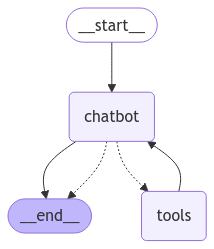

In [10]:
###### Graph Visualization ######
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Adding Human Feedback

Let's now perform **Human-in-the-loop** !

In [11]:
from langchain_core.runnables import RunnableConfig

# User input
question = "Please provide the latest news related to AI."

# Define the initial input State
input = State(messages=[("user", question)])

# Config settings
config = RunnableConfig(
    # Visit up to 10 nodes; beyond this, a RecursionError will occur
    recursion_limit=10,
    # Set thread id
    configurable={"thread_id": "1"},
    # Set tags
    tags=["06-LangGraph-Human-in-the-loop"],
)

# Process events in a loop
for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    # Interrupt before executing the tools (stop before the tools node execution)
    interrupt_before=["tools"],
):
    for key, val in event.items():
        # key is the node's name
        # print(f"\n[{key}]\n")

        # val(value) is the node's output
        pretty_print_messages(val)

        # State is stored in dict format within val(value)
        if "messages" in val:
            print(f"Number of messages: {len(val['messages'])}")

================================ Human Message =================================

Please provide the latest news related to AI.
================================ Human Message =================================

Please provide the latest news related to AI.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_JFu8CvoZ7QlIzVnKky1rMgCn)
 Call ID: call_JFu8CvoZ7QlIzVnKky1rMgCn
  Args:
    query: AI


The chatbot invoked the tool, but its execution was interrupted.

Let's check the graph state!

In [12]:
# snapshot of the graph state
snapshot = graph.get_state(config)
snapshot.next

('tools',)

The reason for the interruption is that we set `tools` in `interrupt_before` while streaming the graph, causing the process to stop before executing the `tools` node. As a result, the next node ( `.next` ) becomes `tools` .

Additionally, *in the previous tutorial* , `.next` was empty because the process had reached the final `END` node. However, with the interrupt set, `.next` is now set to `tools` .

Now, let's check the last message in the snapshot!

In [13]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'search_keyword',
  'args': {'query': 'AI'},
  'id': 'call_JFu8CvoZ7QlIzVnKky1rMgCn',
  'type': 'tool_call'}]

Next, let's resume the graph from the point where it was interrupted.

**LangGraph** makes it easy to resume graph execution.

Simply pass `None` as the `input` .

In [14]:
events = graph.stream(
    input=None,  # Do not add anything to the current State
    config=config,
    stream_mode="values",
)

# Process events in a loop
for event in events:
    if "messages" in event:
        # Print the last message
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_JFu8CvoZ7QlIzVnKky1rMgCn)
 Call ID: call_JFu8CvoZ7QlIzVnKky1rMgCn
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMikwFBVV95cUxNcllEYjZmTkNzUGpjenpxZ3N6ZlFOcFAxS2szNm80MWM4dVRSU3YzcGlzU0xrZkI3MEpBR3N2U19lSmdmVnR5R0dhT0U4S1RHR1JWZDlvTXd1MnU1TlNyZlRuYXVpS0cxY1pjckNaQU1URE9IV2kzZm96d2dYRWVUczBrYV9HUklmVDJNOElaTEVNMUHSAYoBQVVfeXFMTkttd0EzSUNJUnR5ak5UYWNfZWhpVHlrZFMxQ095TTVOb2JTX2RLSTZQV2dDNktvbTktR1B4bDBtRlpxUlJhck9mTGgzVDBzMXpTaXR6aEZ2VndnRElvaFNNcGE4VmtwTjdVcXVjYkU2SnlaUGZDSXRRUjZxb3RJSHFFcTZCVWpiaWJB?oc=5", "content": "Trump announces a $500 billion AI infrastructure investment in the US - CNN"}, {"url": "https://news.google.com/rss/articles/CBMinAFBVV95cUxOUFlLYjE5VkkyR0F4Vl9JYVVtSDl0Vk5hcHVLZ2h2bUgweE00NFplTFhDLWFBNDNpRlN0OXJiQ1JjSFNadmU2Z1BDaVpPM

We used **interrupt** to enable **human intervention** in the chatbot's execution.

Additionally, with the inclusion of a `checkpointer` , the graph can resume execution even after being indefinitely paused.

Below is how you can use `get_state_history` to retrieve the state history.

By specifying the desired state from the history, you can restart execution from that point.

In [15]:
to_replay = None

# Retrieve state history
for state in graph.get_state_history(config):
    print(
        "Number of messages:", len(state.values["messages"]), "\nNext node:", state.next
    )
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        to_replay = state

Number of messages: 4 
Next node: ()
--------------------------------------------------------------------------------
Number of messages: 3 
Next node: ('chatbot',)
--------------------------------------------------------------------------------
Number of messages: 2 
Next node: ('tools',)
--------------------------------------------------------------------------------
Number of messages: 1 
Next node: ('chatbot',)
--------------------------------------------------------------------------------
Number of messages: 0 
Next node: ('__start__',)
--------------------------------------------------------------------------------


It is important to note that the `checkpointer` saves data at every step of the graph!

The desired point is stored in `to_replay` . This allows you to specify the starting point for resuming execution.

The `checkpoint_id` is stored in `to_replay.config` .

In [16]:
display(to_replay.next)
display(to_replay.config)

('chatbot',)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd8a06-ace9-6516-8002-8731d8cb463e'}}

Using this `checkpoint_id` , LangGraph's checkpointer can load the state at that specific point. 

Note that the `input` must be set to `None` in this case.

In [17]:
for event in graph.stream(input=None, config=to_replay.config, stream_mode="values"):
    if "messages" in event:
        # Print the last message
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMikwFBVV95cUxNcllEYjZmTkNzUGpjenpxZ3N6ZlFOcFAxS2szNm80MWM4dVRSU3YzcGlzU0xrZkI3MEpBR3N2U19lSmdmVnR5R0dhT0U4S1RHR1JWZDlvTXd1MnU1TlNyZlRuYXVpS0cxY1pjckNaQU1URE9IV2kzZm96d2dYRWVUczBrYV9HUklmVDJNOElaTEVNMUHSAYoBQVVfeXFMTkttd0EzSUNJUnR5ak5UYWNfZWhpVHlrZFMxQ095TTVOb2JTX2RLSTZQV2dDNktvbTktR1B4bDBtRlpxUlJhck9mTGgzVDBzMXpTaXR6aEZ2VndnRElvaFNNcGE4VmtwTjdVcXVjYkU2SnlaUGZDSXRRUjZxb3RJSHFFcTZCVWpiaWJB?oc=5", "content": "Trump announces a $500 billion AI infrastructure investment in the US - CNN"}, {"url": "https://news.google.com/rss/articles/CBMinAFBVV95cUxOUFlLYjE5VkkyR0F4Vl9JYVVtSDl0Vk5hcHVLZ2h2bUgweE00NFplTFhDLWFBNDNpRlN0OXJiQ1JjSFNadmU2Z1BDaVpPMlYtTnBpS2VnQmR5dE9GZFB1c3hQR0NoNUo3ekpFTmFIWjI4TjdjV1ZrbDJ5LURaZ2s1UDhZSkd4cndaQ2pRRENscjNJc2JXZGZyazRmdDU?oc=5", "content": "Trump Announces $100 Billion A.I. Initiative - The New York Times"}, {"url": "